In [1]:
import os
import json, yaml
from json import JSONEncoder
import glob
from itertools import groupby

import numpy as np

import cv2
from PIL import Image
import skimage.io as io
from skimage import measure
import matplotlib.pyplot as plt

from collections import OrderedDict
from pycocotools import mask 
from pycocotools.coco import COCO

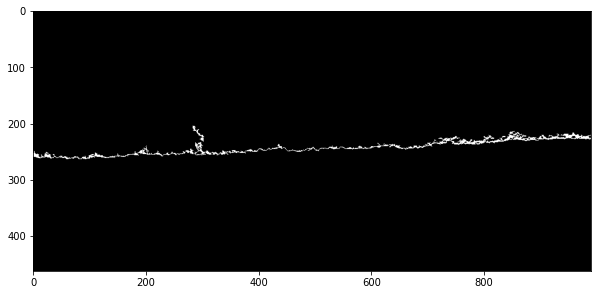

2581 3585


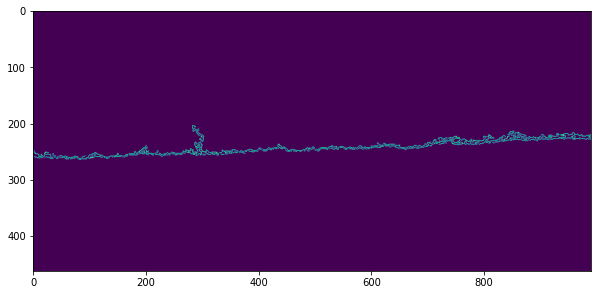

In [2]:
root_path = "/home/joo/Downloads/crack_dataset/"
top_folder = sorted(os.listdir(root_path))
number_of_folder = 0
mid_folder = "/masks/*" # /train/masks/*
bot_folder = ""


In [3]:
def get_annotation(mask_img, image=None):

    contours, _ = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    segmentation = []
    for contour in contours:
        # Valid polygons have >= 6 coordinates (3 points)
        if contour.size >= 6:
            segmentation.append(contour.flatten().tolist())

    RLEs = mask.frPyObjects(segmentation, mask_img.shape[0], mask_img.shape[1])
    RLE = mask.merge(RLEs)
    # RLE = cocomask.encode(np.asfortranarray(mask))
    area = mask.area(RLE)
    [x, y, w, h] = cv2.boundingRect(mask_img)

    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.drawContours(image, contours, -1, (0,255,0), 1)
        cv2.rectangle(image,(x,y),(x+w,y+h), (255,0,0), 2)
        cv2.imshow("", image)
        cv2.waitKey(1)

    return segmentation, [x, y, w, h], area

def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')

    last_elem = 0
    running_length = 0

    # Fortran과 같은 순서로 인덱싱하여 배열(열 배열)
    for i, elem in enumerate(binary_mask.ravel(order='F')):
        if elem == last_elem:
            pass
        else:
            counts.append(running_length)
            running_length = 0
            last_elem = elem
        running_length += 1

    counts.append(running_length)

    return rle    

class BytesEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, bytes):
            return obj.decode('utf-8')
        return json.JSONEncoder.default(self, obj)

In [34]:
root_path = "/home/joo/Downloads/crack_dataset/"
top_folder = sorted(os.listdir(root_path))
number_of_folder = 0
mid_folder = "/masks/*" # /train/masks/*
bot_folder = ""

target_img = list(map(lambda x : x, sorted(glob.glob(root_path+top_folder[number_of_folder]+"/images/*"+bot_folder))))
target = list(map(lambda x : x, sorted(glob.glob(root_path+top_folder[number_of_folder]+mid_folder+bot_folder))))

num = 1

# coco json init
json_file = {"info":{"description":"KORAD 2022 Dataset","url":"https://www.sierrabase.co.kr/", 
"version":"1.0","year":2022,"contributor":"jylee","data_created":"2022/09/07"},
"images":[],"annotations":[],
"categories":[{"supercategory":"korad","id":1,"name":"concreteCrack"}]} 


for index, file in enumerate(target):
    temp = cv2.imread(file,0)
    height,width = temp.shape
    mask_index = np.where(temp == (255),1,0)
    
    cnt = 1
    y_num = 0

    json_file["images"].append({"id":int(target_img[index].split(".")[0][-5:]),
    "file_name":target_img[index].split(".")[0][-5:]+"."+target_img[index].split(".")[1],
    "height":height,"width":width})

    if len(mask_index[0]) < 1 :
        # background image 
        json_file["annotations"].append({"image_id":int(target_img[index].split(".")[0][-5:]),"id":num, "category_id":"","bbox":[],"area":"",
        "segmentation":[],"iscrowd":""})
        num = num + 1
        continue
    
    
    fortran_ground_truth_binary_mask = np.asfortranarray(mask_index)
    rle = binary_mask_to_rle(fortran_ground_truth_binary_mask)
    
    compressed_rle = mask.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    area = mask.area(compressed_rle)
    bbox = mask.toBbox(compressed_rle)

    json_file["annotations"].append({"image_id":int(target_img[index].split(".")[0][-5:]),"id":num, "category_id":1,
    # bbox : top-left-x, top-left-y, width, height
    "bbox":mask.toBbox(compressed_rle).tolist(),
    "area":int(mask.area(compressed_rle)),"segmentation":rle,"iscrowd":0})

    num = num + 1


with open("train2022.json",'w', encoding='utf-8') as f:
    json.dump(json_file, f)

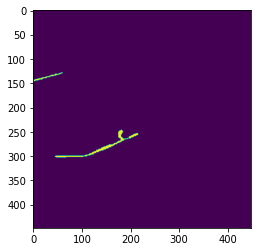

37


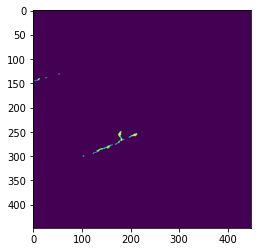

In [96]:
a = cv2.imread("/home/joo/Downloads/crack_dataset/3_Conglomerate_Concrete_Crack_Detection/train/masks/01089_GT.jpg", 0)
b = a.copy()

plt.imshow(a)
plt.show()
plt.close()

seg, bbox, area = get_annotation(mask_img=a)

# print(seg, bbox, area)

contours, _ = cv2.findContours(b, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))

for contour in contours:
    b = cv2.drawContours(b, [contour], -1, (0,0,255),2)
plt.imshow(b)
plt.show()
plt.close()

In [ ]:
target = list(map(lambda x : x, sorted(glob.glob(root_path+top_folder[number_of_folder]+mid_folder+bot_folder))))

# json_file = {"images":[{"id":0,"file_name":"000001.jpg","height":height,"width":width}],
# "annotations":[{"image_id":str(1).zfill(5),"id":0, "category_id":0,"bbox":[]}],"categories":[]}

# img = 255 - img <-- 색반전
cnt = 0

for index, file in enumerate(target):
    # if index != 30: continue
    img = cv2.imread(file)
    img = np.where(img >= 245, 255, 0)
    img = np.uint8(img)

    plt.figure(figsize=(10,10))
    plt.imshow(img)
    plt.show()
    plt.close()      
    
    # cv2.imwrite("./temp/temp_origin.png",img)

    edge = cv2.Canny(img,245,255)
    height, width = edge.shape
    
    cnt = 0
    cnt_origin = 0
    for he_num in range(height):
        for wi_num in range(width):
            if edge[he_num][wi_num] != 0:
                cnt = cnt + 1
            if img[he_num][wi_num].any() != 0:
                cnt_origin = cnt_origin + 1

    print(cnt,cnt_origin)

    plt.figure(figsize=(10,10))
    plt.imshow(edge)
    plt.show()
    plt.close()

    # cv2.imwrite("./temp/temp.png",edge)
    break

{'counts': [6, 9, 3, 3], 'size': [3, 7]}
b'61X13mN000`0'
<class 'dict'>
[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [0 0 0 0 0 1 1 1 0 0]
 [1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]


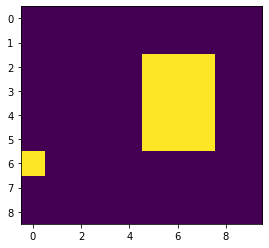

In [24]:
# test_list_1 = np.array([0, 0, 1, 1, 1, 0, 1])

test_list_1 = np.array([[0, 0, 1, 1, 1, 0, 1],
                        [0, 0, 1, 1, 1, 0, 1],
                        [0, 0, 1, 1, 1, 0, 1]])
# test_list_2 = np.array([1, 1, 1, 1, 1, 1, 0])

print(binary_mask_to_rle(test_list_1))
# print(binary_mask_to_rle(test_list_2))

ground_truth_binary_mask = np.array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  0,   0,   0,   0,   0,   1,   1,   1,   0,   0],
                                     [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
                                     [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0]], dtype=np.uint8)

fortran_ground_truth_binary_mask = np.asfortranarray(ground_truth_binary_mask)

rle = binary_mask_to_rle(fortran_ground_truth_binary_mask)

compressed_rle = mask.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
print(compressed_rle['counts'])
print(type(compressed_rle))
w = mask.decode(compressed_rle)
print(w)

plt.imshow(w)

In [31]:
coco = COCO('temp.json')

# display COCO categories and supercategories
cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

# get all images containing given categories, select one at random
catIds = coco.getCatIds(catNms=['concreteCrack'])
imgIds = coco.getImgIds(catIds=catIds )
print(imgIds)
imgIds = coco.getImgIds(imgIds = [78])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
concreteCrack

COCO supercategories: 
korad
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170]


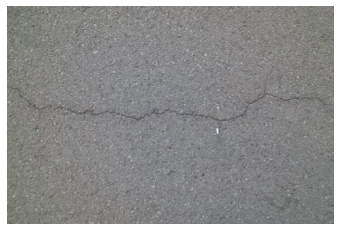

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


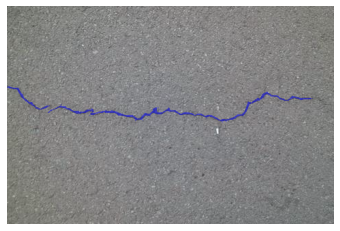

In [32]:
# load and display image
# I = io.imread('%s/images/%s/%s'%(dataDir,dataType,img['file_name']))
# use url to load image
I = io.imread(root_path+top_folder[number_of_folder]+"/images/"+img['file_name'])
I = cv2.cvtColor(I, cv2.COLOR_RGB2BGR)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display instance annotations
plt.imshow(I); plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
# print(anns)
coco.showAnns(anns)